In [1]:
import os,sys
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
from spatialOmics import SpatialOmics
import spatialHeterogeneity as sh
import seaborn as sns
from statannotations.Annotator import Annotator

In [2]:
from spatialHeterogeneity.utils.general import is_numeric, is_categorical, make_iterable
from spatialHeterogeneity.plotting.utils import dpi, label_fontdict, title_fontdict, make_cbar 
from matplotlib.colors import Normalize, NoNorm, to_rgba, to_rgb, Colormap, ListedColormap
from matplotlib import cm
def savefig(fig, save):
    # if only filename is given, add root_fig, convenient to save plots less verbose.
#     if save == os.path.basename(save):
#         save = os.path.join(plt.rcParams['savefig.directory'], save)
    fig.savefig(save)
    print(f'Figure saved at: {save}')

def custom_spatial(so, spl: str, attr: str, *, mode: str = 'scatter', node_size: float = 4, coordinate_keys: list = ['x', 'y'],
            mask_key: str = 'cellmasks', graph_key: str = 'knn', edges: bool = False, edge_width: float = .5,
            edge_color: str = 'black', edge_zorder: int = 2, background_color: str = 'white', ax: plt.Axes = None,
            norm=None, set_title: bool = True, cmap=None, cmap_labels: list = None, cbar: bool = True,
            cbar_title: bool = True, show: bool = True, save: str = None, tight_layout: bool = True):
    """Various functionalities to visualise samples.
    Allows to visualise the samples and color observations according to features in either so.X or so.obs by setting the ``attr`` parameter accordingly.
    Furthermore, observations (cells) within a sample can be quickly visualised using scatter plots (requires extraction of centroids with :func:`~.extract_centroids`)
    or by their actual segmentatio mask by setting ``mode`` accordingly.
    Finally, the graph representation of the sample can be overlayed by setting ``edges=True`` and specifing the ``graph_key`` as in ``so.G[spl][graph_key]``.
    For more examples on how to use this function have a look at the tutorial_ section.
    Args:
        so: SpatialOmics instance
        spl: sample to visualise
        attr: feature to visualise
        mode: {scatter, mask}. In `scatter` mode, observations are represented by their centroid, in `mask` mode by their actual segmentation mask
        node_size: size of the node when plotting the graph representation
        coordinate_keys: column names in SpatialOmics.obs[spl] that indicates the x and y coordinates
        mask_key: key for the segmentation masks when in `mask` mode
        graph_key: which graph representation to use
        edges: whether to plot the graph or not
        edge_width: width of edges
        edge_color: color of edges as string
        edge_zorder: z-order of edges
        background_color: background color of plot
        ax: axes object in which to plot
        norm: normalisation instance to normalise the values of `attr`
        set_title: title of plot
        cmap: colormap to use
        cmap_labels: colormap labels to use
        cbar: whether to plot a colorbar or not
        cbar_title: whether to plot the `attr` name as title of the colorbar
        show: whether to show the plot or not
        save: path to the file in which the plot is saved
        tight_layout: whether to apply tight_layout or not.
    Examples:
        .. code-block:: python
            so = sh.dataset.imc()
            sh.pl.spatial(so, 'slide_7_Cy2x2', 'meta_id', mode='mask')
            sh.pl.spatial(so, 'slide_7_Cy2x2', 'meta_id', mode='scatter', edges=True)
    .. _tutorial: https://ai4scr.github.io/ATHENA/source/tutorial.html
    """
    # get attribute information
    data = None  # pd.Series/array holding the attr for colormapping
    colors = None  # array holding the colormappig of data

    # try to fetch the attr data
    if attr:
        if attr in so.obs[spl].columns:
            data = so.obs[spl][attr]
        elif attr in so.X[spl].columns:
            data = so.X[spl][attr]
        else:
            raise KeyError(f'{attr} is not an column of X nor obs')
    else:
        colors = 'black'
        cmap = 'black'
        cbar = False

    # broadcast if necessary
    _is_categorical_flag = is_categorical(data)

    loc = so.obs[spl][coordinate_keys].copy()

    # set colormap
    if cmap is None:
        cmap, cmap_labels = get_cmap(so, attr, data)
    elif isinstance(cmap, str) and colors is None:
        cmap = plt.get_cmap(cmap)

    # normalisation
    if norm is None:
        if _is_categorical_flag:
            norm = NoNorm()
        else:
            norm = Normalize()

    # generate figure
    if ax:
        fig = ax.get_figure()
        show = False  # do not automatically show plot if we provide axes
    else:
        fig, ax = plt.subplots(dpi=dpi)
        ax.set_aspect('equal')

    # compute edge lines
    if edges:
        g = so.G[spl][graph_key]
        e = np.array(g.edges, dtype=type(loc.index.dtype))

        tmp1 = loc.loc[e.T[0]]
        tmp2 = loc.loc[e.T[1]]

        x = np.stack((tmp1[coordinate_keys[0]], tmp2[coordinate_keys[0]]))
        y = np.stack((tmp1[coordinate_keys[1]], tmp2[coordinate_keys[1]]))

        # we have to plot sequentially nodes and edges, this takes a bit longer but is more flexible
        im = ax.plot(x, y, linestyle='-', linewidth=edge_width, marker=None, color=edge_color, zorder=edge_zorder)

    # plot
    if mode == 'scatter':
        # convert data to numeric
        data = np.asarray(
            data) if data is not None else None  # categorical data does not work with cmap, therefore we construct an array
        _broadcast_to_numeric = not is_numeric(data)  # if data is now still categorical, map to numeric

        if _broadcast_to_numeric and data is not None:
            if attr in so.uns['cmap_labels']:
                cmap_labels = so.uns['cmap_labels'][attr]
                encoder = {value: key for key, value in cmap_labels.items()}  # invert to get encoder
#                 print(encoder)
            else:
                uniq = np.unique(data)
                encoder = {i: j for i, j in zip(uniq, range(len(uniq)))}
                cmap_labels = {value: key for key, value in encoder.items()}  # invert to get cmap_labels

            data = np.asarray([encoder[i] for i in data])

        # map to colors
        if colors is None:
            no_na = data[~np.isnan(data)]
            _ = norm(no_na)  # initialise norm with no NA data.

            colors = cmap(norm(data))
#             print('Check_point cmap2colors',colors)

        im = ax.scatter(loc[coordinate_keys[0]], loc[coordinate_keys[1]], s=node_size, c=colors, zorder=2.5)
        ax.set_facecolor(background_color)

    elif mode == 'mask':

        # get cell mask
        mask = so.get_mask(spl, mask_key)

        # generate mapping
        if data is not None:
            mapping = data.to_dict()
        elif colors:
            # case in which attr is a color
            uniq = np.unique(mask)
            uniq = uniq[uniq != 0]
            mapping = {i: j for i, j in zip(uniq, np.ones(len(uniq), dtype=int))}  # map everything to 1
            cmap = ListedColormap([to_rgba('white'), colors])
        else:
            raise RuntimeError('Unknown case')
        mapping.update({0: 0})
        mapping.update({np.nan: np.nan})

        # apply mapping vectorized
        otype = ['int'] if _is_categorical_flag else ['float']
        func = np.vectorize(lambda x: mapping[x], otypes=otype)
        im = func(mask)

        # convert to masked array to handle np.nan values
        im = np.ma.array(im, mask=np.isnan(im))

        # plot
        im = cmap(norm(im))
        im[mask == 0] = to_rgba(background_color)
        imobj = ax.imshow(im)
        ax.invert_yaxis()

    else:
        raise ValueError(f'Invalide plotting mode {mode}')

    # add colorbar
    if cbar:
        title = attr
        if cbar_title is False:
            title = ''
        make_cbar(ax, title, norm, cmap, cmap_labels)

    # format plot
    ax_pad = min(loc[coordinate_keys[0]].max() * .05, loc[coordinate_keys[1]].max() * .05, 10)
    ax.set_xlim(loc[coordinate_keys[0]].min() - 0.05, loc[coordinate_keys[0]].max() + 0.05)
    ax.set_ylim(loc[coordinate_keys[1]].min() - 0.05, loc[coordinate_keys[1]].max() + 0.05)
#     ax.set_xticks([]);
#     ax.set_yticks([])
#     ax.set_xlabel('spatial x', label_fontdict)
#     ax.set_ylabel('spatial y', label_fontdict)
    ax.set_aspect(1)
    if set_title:
        title = f'{spl}' if cbar else f'{spl}, {attr}'
        ax.set_title(title, title_fontdict)

    if tight_layout:
        fig.tight_layout()

    if show:
        fig.show()

    if save:
        savefig(fig, save)
    

def get_cmap(so, attr: str, data):
    '''
    Return the cmap and cmap labels for a given attribute if available, else a default
    Parameters
    ----------
    so: IMCData
        so object form which to fetch the data
    spl: str
        spl for which to get data
    attr: str
        attribute for which to get the cmap and cmap labels if available
    Returns
    -------
    cmap and cmap labels for attribute
    '''

    # TODO: recycle cmap if more observations than colors
    cmap, cmap_labels = None, None
    if attr in so.uns['cmaps'].keys():
        cmap = so.uns['cmaps'][attr]
    elif is_categorical(data):
        cmap = so.uns['cmaps']['category']
    else:
        cmap = so.uns['cmaps']['default']

    if attr in so.uns['cmap_labels'].keys():
        cmap_labels = so.uns['cmap_labels'][attr]
#     print(cmap, cmap_labels)
    return cmap, cmap_labels

In [3]:
# set path ------------------
output_dir = '/scratch/project/stseq/Feng/projects/SkinCancerAtlas/Revision/manuscript_code/figS10'
clean_dir = '/scratch/project/stseq/Feng/SkinCancerAtlas/clean-data'
os.chdir(output_dir)

## load data

In [4]:
anno = pd.read_csv('/scratch/project/stseq/Feng/SkinCancerAtlas/process-data/CosMx_annotation_Sam.csv')
anno['patient_cancer_fov'] = anno['patitent_cancer']+'_'+ anno['CosMx IF'].astype('str')
anno_d = dict(zip(anno['patient_cancer_fov'], anno['Primary']))

In [8]:
patient_cancer_d = {'P30':'SCC', 'B18_SCC':'SCC', '6747-085P':'Melanoma', 'B18_BCC':'BCC', '66487-1A':'Melanoma', 'P13':'SCC', 'D12':'BCC', '48974-2B':'Melanoma', '21031-08TB':'Melanoma'}
so = SpatialOmics()
for patient in patient_cancer_d.keys():
    h5ad_name = patient +'_labeled_cosmx.h5ad'
    adata = sc.read_h5ad(os.path.join(clean_dir,h5ad_name))
    adata.obs.loc[:,'patient'] = patient.split('_')[0]
    adata.obs.loc[:,'cancer_type'] = patient_cancer_d[patient]
    adata.obs.loc[:,'patient_cancer'] = adata.obs['patient']+'_'+adata.obs['cancer_type']
    adata.obs.loc[:,'patient_cancer_fov'] = adata.obs.loc[:,'patient_cancer']+'_'+adata.obs.loc[:,'fov'].astype(str)
    adata.obs.loc[:,'Primary'] = adata.obs['patient_cancer_fov'].map(anno_d)
    adata = adata[~adata.obs['CenterX_global_px'].isna()]
    
    for fov in adata.obs['patient_cancer_fov'].unique():
        sub_adata = adata[adata.obs['patient_cancer_fov'] == fov]            
        so.X[fov] = pd.DataFrame(sub_adata.X.toarray(),index=sub_adata.obs.index)
        so.obs[fov] = sub_adata.obs
        so.var[fov] = sub_adata.var
        #coord = sub_adata.obsm['spatial']
    #    coord.rename(columns={'sdimx':'x', 'sdimy':'y'}, inplace=True)
    #     coord = pd.DataFrame(coord, index=smi_spatial_omic.obs[sample_fov].index, columns=['x','y'])
        #so.obs[i] = pd.concat([smi_spatial_omic.obs[i], coord], axis = 1)
so.spl = pd.concat(so.obs, axis=0).loc[:,['fov','patient','cancer_type','patient_cancer','patient_cancer_fov','Primary']].drop_duplicates().set_index('patient_cancer_fov', drop=False)

## compute metrics at cell level

In [9]:
# import default graph builder parameters
from spatialHeterogeneity.graph_builder.constants import GRAPH_BUILDER_DEFAULT_PARAMS
GRAPH_BUILDER_DEFAULT_PARAMS
# kNN graph
config = GRAPH_BUILDER_DEFAULT_PARAMS['knn']
config['builder_params']['n_neighbors'] = 6 # set parameter k

# radius graph
config = {'builder_params': {'radius': 50,
            'mode': 'connectivity',
            'metric': 'minkowski',
            'p': 2,
            'metric_params': None,
            'include_self': True,
            'n_jobs': -1}}
# config['builder_params']['radius'] = 0.02 # set radius
config


{'builder_params': {'radius': 50,
  'mode': 'connectivity',
  'metric': 'minkowski',
  'p': 2,
  'metric_params': None,
  'include_self': True,
  'n_jobs': -1}}

In [10]:
spl='B18_SCC_15'
key_entroy = 'quadratic_radius'
so.uns['cmaps'].update({'default': cm.plasma})
# del so.obs[spl][key_entroy] 
sh.graph.build_graph(so, spl, builder_type='radius', mask_key=None, coordinate_keys=('CenterX_global_px', 'CenterY_global_px'),config=config)
sh.metrics.quadratic_entropy(so, spl, 'predicted.id',local=True, graph_key='radius', metric='cosine', key_added=key_entroy)
# sh.pl.spatial(so, spl, 'quadratic_predicted.id_radius', coordinate_keys=['CenterX_global_px', 'CenterY_global_px'], cbar_title=False, background_color='black')
# custom_spatial(so, spl, key_entroy, node_size=20, cbar=True, background_color='black',coordinate_keys=['CenterX_global_px', 'CenterY_global_px'])

/scratch/project_mnt/S0010/Feng/SkinCancerAtlas/athena/spatialHeterogeneity/metrics/heterogeneity/metrics.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features = features.groupby(attr).mean()


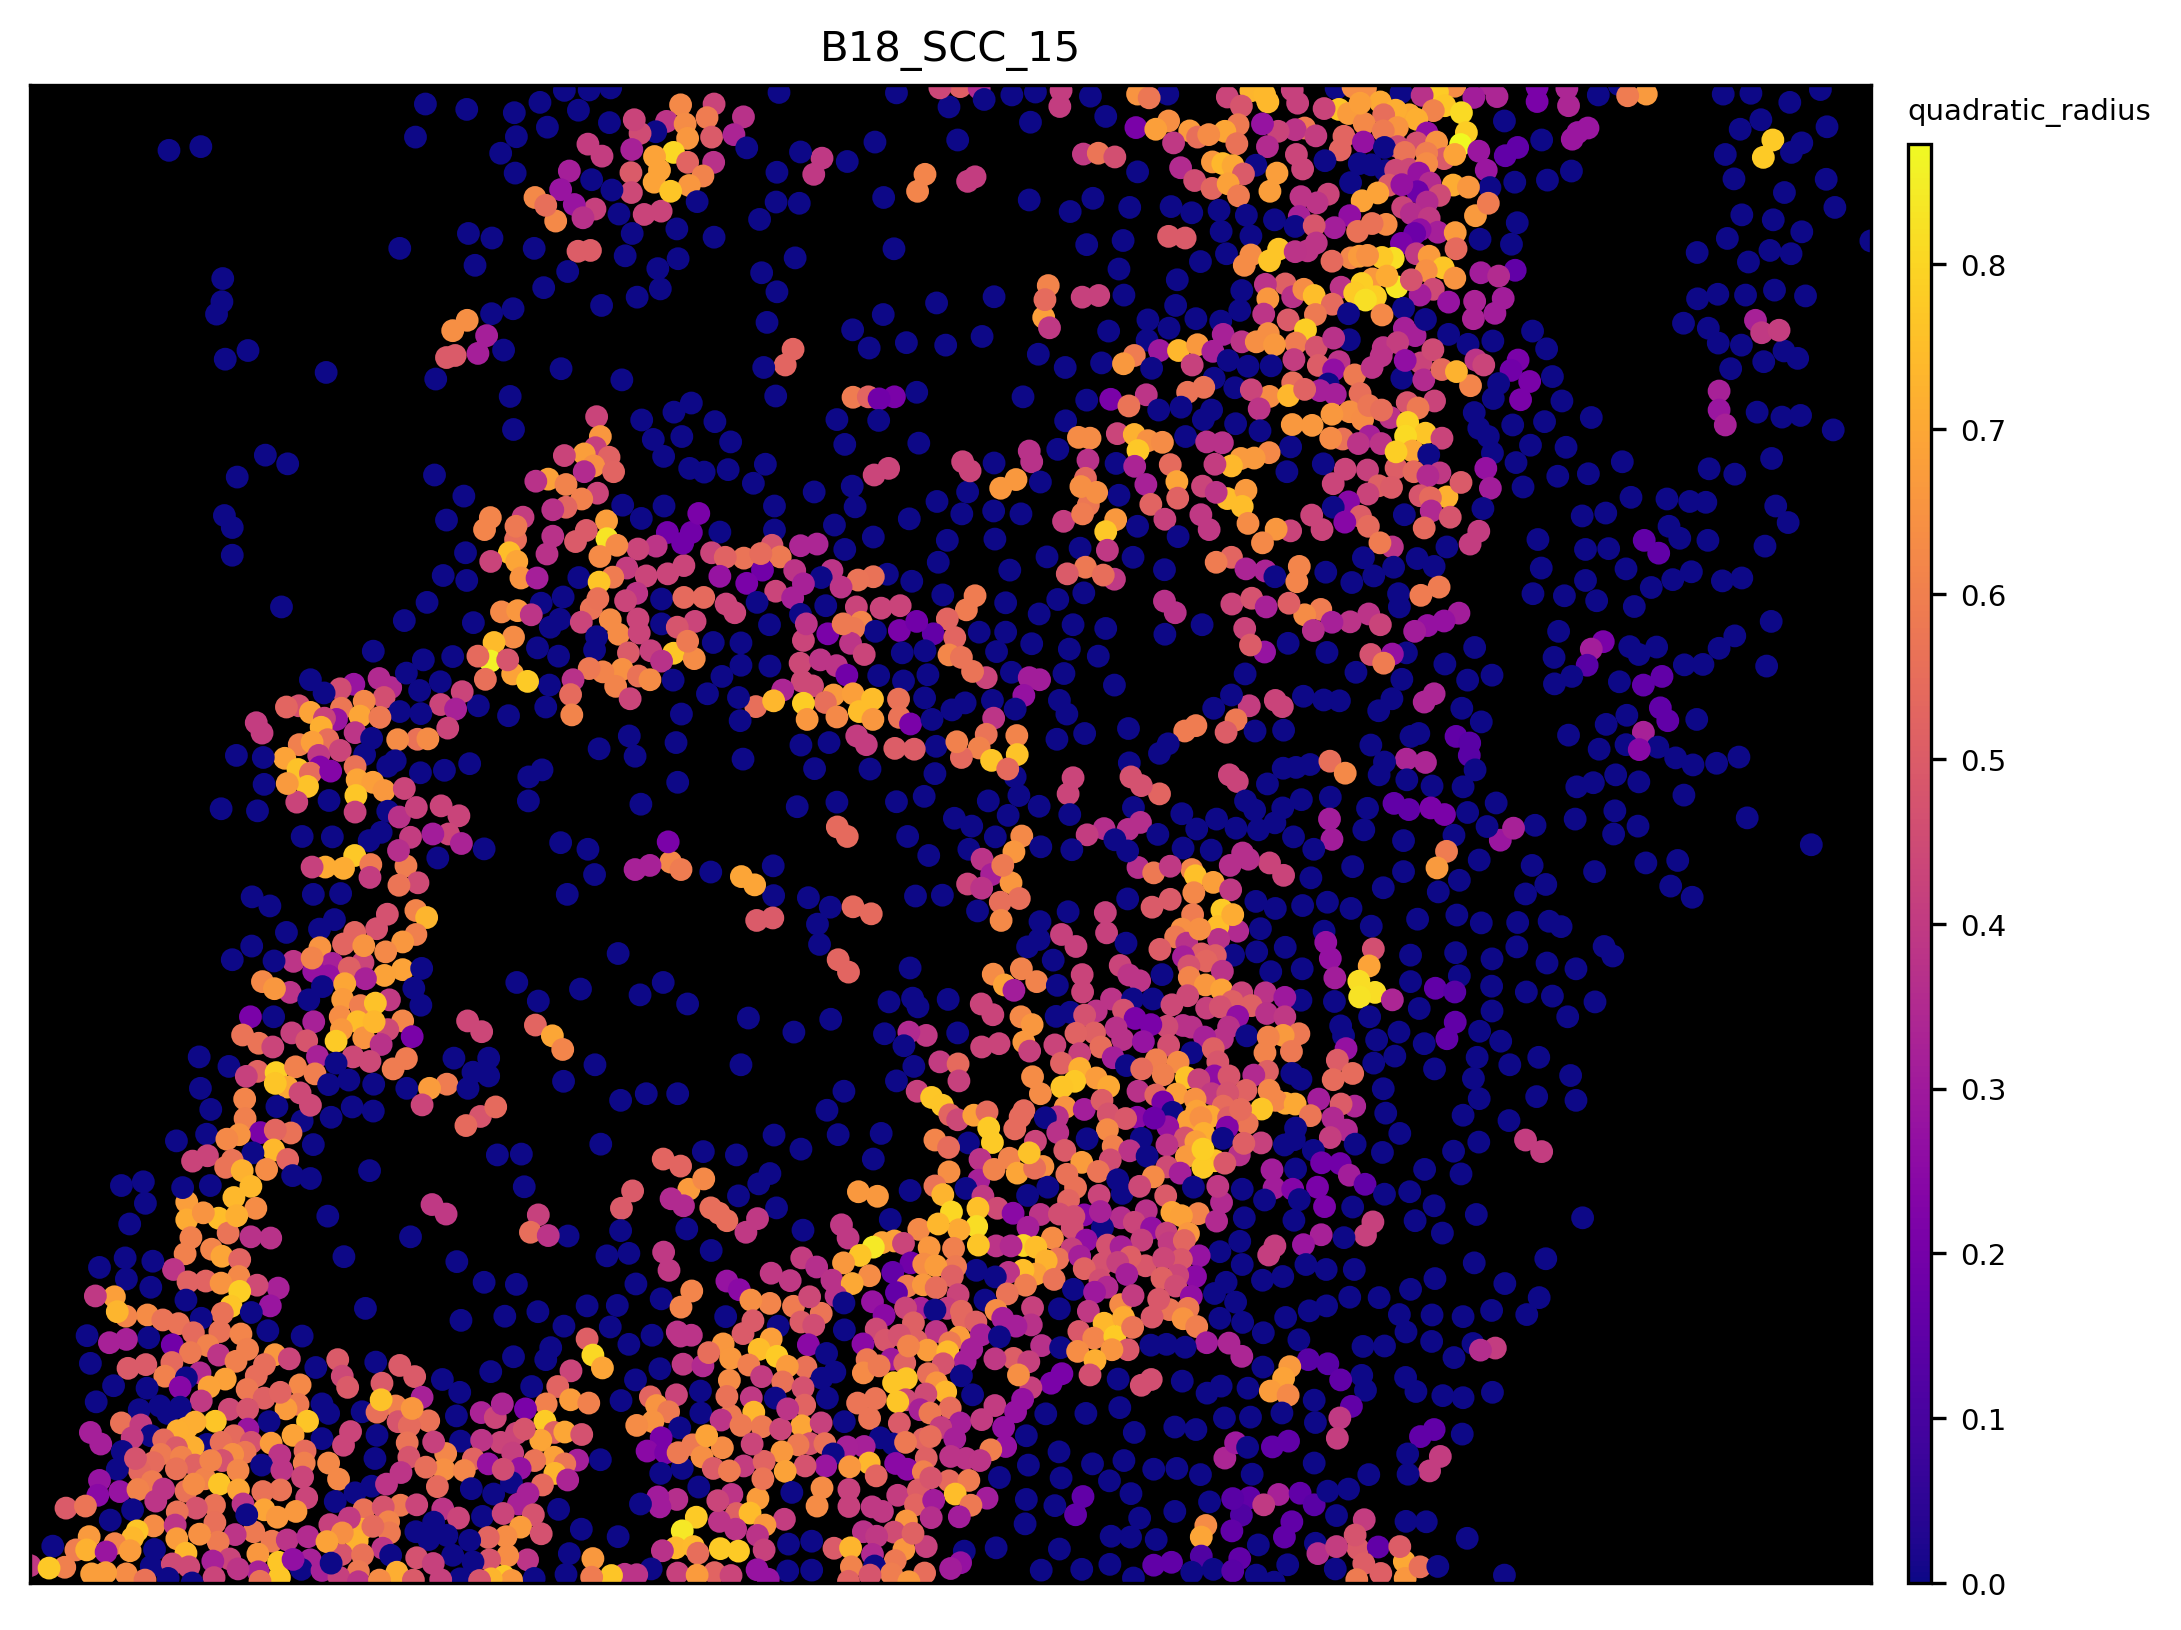

In [27]:
fig, ax = plt.subplots(figsize=(8, 8), dpi=300)
custom_spatial(so, spl, key_entroy, node_size=20, cbar=True, background_color='black',coordinate_keys=['CenterX_global_px', 'CenterY_global_px'],ax=ax)
plt.xticks([])  # Remove x ticks
plt.yticks([])
fig.savefig(f'{spl}_h2.pdf', transparent=False, dpi=300, bbox_inches="tight")

## compute metrics at a sample level

In [12]:
# compute metrics at a sample level
for s in so.obs.keys():
    sh.metrics.richness(so, s, 'predicted.id', local=False)
    sh.metrics.shannon(so, s, 'predicted.id', local=False)
    sh.metrics.quadratic_entropy(so, s, 'predicted.id',local=False)
    sh.metrics.simpson(so, s,'predicted.id', local=False)
# estimated values are saved in so.spl  

/scratch/project_mnt/S0010/Feng/SkinCancerAtlas/athena/spatialHeterogeneity/metrics/heterogeneity/metrics.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features = features.groupby(attr).mean()
/scratch/project_mnt/S0010/Feng/SkinCancerAtlas/athena/spatialHeterogeneity/metrics/heterogeneity/metrics.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  features = features.groupby(attr).mean()
/scratch/project_mnt/S0010/Feng/SkinCancerAtlas/athena/spatialHeterogeneity/metrics/heterogeneity/metrics.py:249: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future v

In [13]:
sample_level_metric = so.spl.copy()
sample_level_metric

,fov,patient,cancer_type,patient_cancer,patient_cancer_fov,Primary,richness_predicted.id,shannon_predicted.id,quadratic_predicted.id,simpson_predicted.id
patient_cancer_fov,,,,,,,,,,
P30_SCC_8,8,P30,SCC,P30_SCC,P30_SCC_8,Healthy,16.0,3.389118,26.671823,0.118387
P30_SCC_9,9,P30,SCC,P30_SCC,P30_SCC_9,Cancer,17.0,3.028910,20.760904,0.180680
P30_SCC_10,10,P30,SCC,P30_SCC,P30_SCC_10,Cancer,16.0,3.026870,21.243054,0.169286
P30_SCC_11,11,P30,SCC,P30_SCC,P30_SCC_11,Cancer,17.0,3.357355,25.813804,0.135406
P30_SCC_12,12,P30,SCC,P30_SCC,P30_SCC_12,Cancer,17.0,3.351550,23.572519,0.120606
...,...,...,...,...,...,...,...,...,...,...
21031-08TB_Melanoma_12,12,21031-08TB,Melanoma,21031-08TB_Melanoma,21031-08TB_Melanoma_12,Healthy,17.0,3.572540,35.689724,0.095794
21031-08TB_Melanoma_13,13,21031-08TB,Melanoma,21031-08TB_Melanoma,21031-08TB_Melanoma_13,Cancer,17.0,3.516520,34.454770,0.099001
21031-08TB_Melanoma_14,14,21031-08TB,Melanoma,21031-08TB_Melanoma,21031-08TB_Melanoma_14,Healthy,16.0,3.143193,29.587208,0.139140


### plot boxplot

In [18]:
numeric_cols = sample_level_metric.select_dtypes(include="number")
sample_level_metric.groupby("cancer_type")[numeric_cols.columns].mean()

,richness_predicted.id,shannon_predicted.id,quadratic_predicted.id,simpson_predicted.id
cancer_type,,,,
BCC,16.291667,3.076898,28.418683,0.163142
Melanoma,16.200000,3.191669,31.336251,0.147489
SCC,16.148148,3.136952,25.086732,0.150411


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

BCC vs. SCC: t-test independent samples, P_val:2.523e-02 t=2.308e+00
SCC vs. Melanoma: t-test independent samples, P_val:3.408e-08 t=-6.415e+00


/tmp/ipykernel_4168994/965606170.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y='quadratic_predicted.id', x='cancer_type', data=sample_level_metric,
/home/uqfzha11/miniforge3/envs/bioPy/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/uqfzha11/miniforge3/envs/bioPy/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/uqfzha11/miniforge3/envs/bioPy/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarn

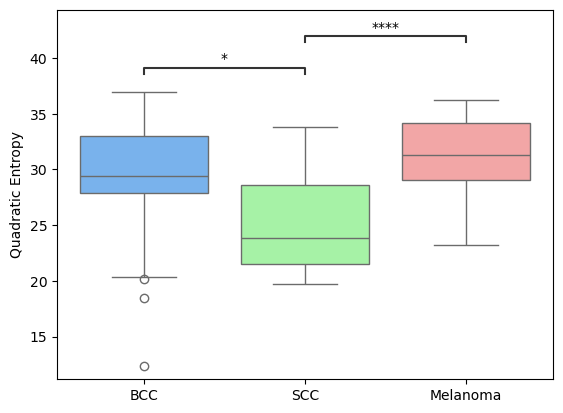

In [21]:
# plot split by cancer type
ax = sns.boxplot(y='quadratic_predicted.id', x='cancer_type', data=sample_level_metric, 
            order=['BCC', 'SCC', 'Melanoma'], palette=['#66B2FF', '#99FF99', '#FF9999'])
ax.set(xlabel=None, ylabel='Quadratic Entropy')
pairs = [('BCC', 'SCC'), ('SCC', 'Melanoma')]
annotator = Annotator(ax, pairs, data=sample_level_metric, y='quadratic_predicted.id', x='cancer_type', order=['BCC', 'SCC', 'Melanoma'])
annotator.configure(test='t-test_ind', text_format='star', loc='inside', verbose=2)
annotator.apply_and_annotate()
plt.savefig('quadratic_cancer_type.pdf', transparent=False, dpi=300, bbox_inches="tight")

### plot barbox split by FOV annotation

In [14]:
anno_level_metric = sample_level_metric[sample_level_metric['Primary']!='Unclear']
anno_level_metric['annotation'] = anno_level_metric['cancer_type']+'_'+anno_level_metric['Primary']
anno_level_metric.head()

/tmp/ipykernel_1160329/740637583.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anno_level_metric['annotation'] = anno_level_metric['cancer_type']+'_'+anno_level_metric['Primary']


,fov,patient,cancer_type,patient_cancer,patient_cancer_fov,Primary,richness_predicted.id,shannon_predicted.id,quadratic_predicted.id,simpson_predicted.id,annotation
patient_cancer_fov,,,,,,,,,,,
P30_SCC_8,8,P30,SCC,P30_SCC,P30_SCC_8,Healthy,16.0,3.389118,26.671823,0.118387,SCC_Healthy
P30_SCC_9,9,P30,SCC,P30_SCC,P30_SCC_9,Cancer,17.0,3.028910,20.760904,0.180680,SCC_Cancer
P30_SCC_10,10,P30,SCC,P30_SCC,P30_SCC_10,Cancer,16.0,3.026870,21.243054,0.169286,SCC_Cancer
P30_SCC_11,11,P30,SCC,P30_SCC,P30_SCC_11,Cancer,17.0,3.357355,25.813804,0.135406,SCC_Cancer
P30_SCC_12,12,P30,SCC,P30_SCC,P30_SCC_12,Cancer,17.0,3.351550,23.572519,0.120606,SCC_Cancer


/home/uqfzha11/miniforge3/envs/bioPy/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/uqfzha11/miniforge3/envs/bioPy/lib/python3.9/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/uqfzha11/miniforge3/envs/bioPy/lib/python3.9/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/uqfzha11/miniforge3/envs/bioPy/lib/python3.9/site-packages/seaborn/categ

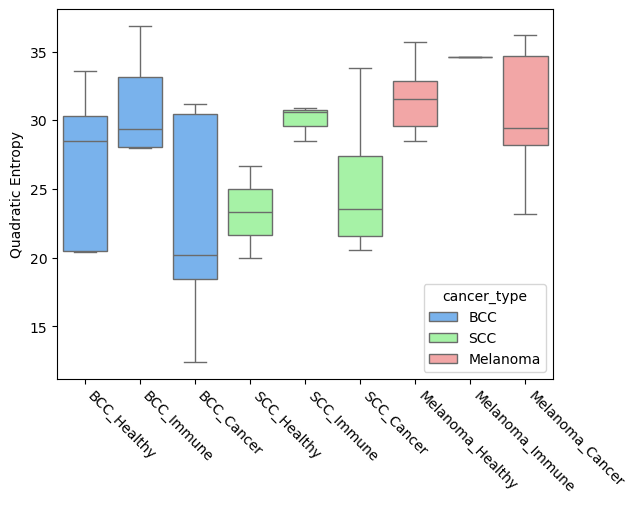

In [30]:
ax = sns.boxplot(y='quadratic_predicted.id', x='annotation', data=anno_level_metric, hue='cancer_type',
            order=['BCC_Healthy','BCC_Immune','BCC_Cancer', 'SCC_Healthy','SCC_Immune','SCC_Cancer', 'Melanoma_Healthy','Melanoma_Immune','Melanoma_Cancer'],
            palette=['#66B2FF', '#99FF99', '#FF9999'],legend=True,hue_order=['BCC','SCC','Melanoma'])
ax.set(xlabel=None, ylabel='Quadratic Entropy')
plt.xticks(rotation=-45, ha='left')
plt.savefig('quadratic_fov_annotation.pdf', transparent=False, dpi=300, bbox_inches="tight")

In [ ]:
#66B2FF 
